# GAN ( Generative Adversarial Network)
## it is a fascinating and powerful type of machine learning model used primarily for generating new data that mimics a given dataset.
in this notebook, it used Mnist dataset

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Reshape
from tensorflow.keras.regularizers import L1L2



In [3]:
# VERSION
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

import keras
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.0
Keras version: 3.4.1


In [4]:
(X_train,_), (_,_) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
X_train.shape

(60000, 28, 28)

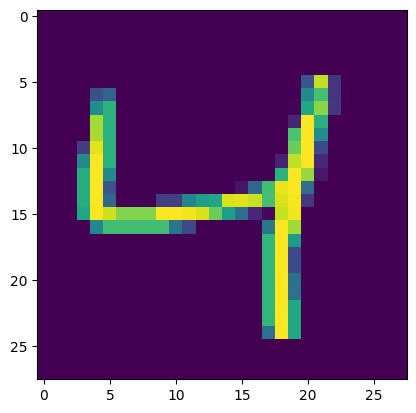

In [6]:
plt.imshow(X_train[2])

In [7]:
# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_train = X_train.batch(256)
X_train = X_train.shuffle(buffer_size=60000)

In [8]:
generator = Sequential()
generator.add(Dense(units=500, input_dim=100, activation='relu', kernel_regularizer=L1L2(1e-5,1e-5)))
generator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5,1e-5)))
generator.add(Dense(units=784, activation='sigmoid', kernel_regularizer=L1L2(1e-5,1e-5))) # vector 28 x 28 size images = 784
generator.add(Reshape((28,28))) # go back to matrix image
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 500)                 │          50,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         392,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,784 (2.65 MB)

 Trainable params: 693,784 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
discriminator = Sequential()
discriminator.add(InputLayer(input_shape=(28,28)))
discriminator.add(Flatten())
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5,1e-5)))
discriminator.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5,1e-5)))
discriminator.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5,1e-5)))
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 500)                 │         392,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 643,501 (2.45 MB)

 Trainable params: 643,501 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# generate images and compare
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [13]:
from operator import ge
epochs = 30
batch_size = 256
noise_dim = 100
seed = tf.random.normal([20, noise_dim])
generator_images = generator(seed)

In [14]:
generator_images.shape

TensorShape([20, 28, 28])

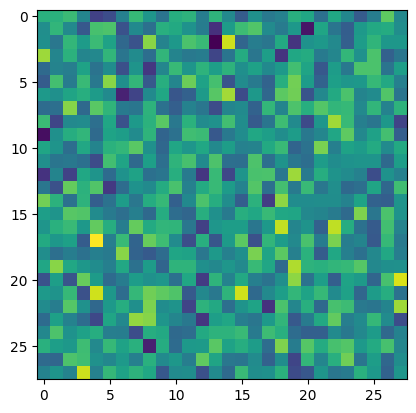

In [15]:
# image generated
plt.imshow(generator_images[0])

In [16]:
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [17]:
for epoch in range(epochs):
    for image_batch in X_train:
        gen_loss, disc_loss = train_step(image_batch)
    print(f'Epoch {epoch+1} , loss from generator {gen_loss}, loss from discriminator {disc_loss}')

Epoch 1 , loss from generator 5.374250888824463, loss from discriminator 0.01156303845345974
Epoch 2 , loss from generator 6.199683666229248, loss from discriminator 0.007653776556253433
Epoch 3 , loss from generator 8.389873504638672, loss from discriminator 0.0014034979976713657
Epoch 4 , loss from generator 8.840600967407227, loss from discriminator 0.0006458470597863197
Epoch 5 , loss from generator 7.824274063110352, loss from discriminator 0.0005411605234257877
Epoch 6 , loss from generator 6.735352039337158, loss from discriminator 0.002350456081330776
Epoch 7 , loss from generator 9.02932357788086, loss from discriminator 0.0003175708116032183
Epoch 8 , loss from generator 14.703856468200684, loss from discriminator 3.2680716685717925e-05
Epoch 9 , loss from generator 9.631378173828125, loss from discriminator 0.0001451034186175093
Epoch 10 , loss from generator 8.385294914245605, loss from discriminator 0.0002548063057474792
Epoch 11 , loss from generator 13.49020767211914, lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


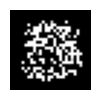

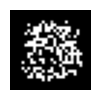

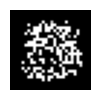

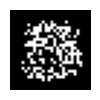

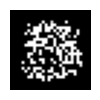

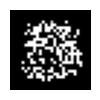

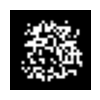

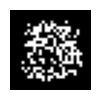

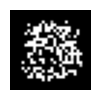

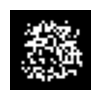

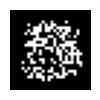

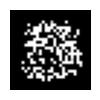

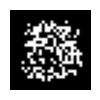

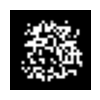

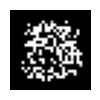

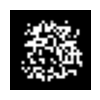

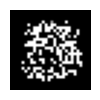

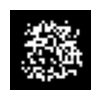

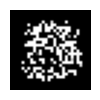

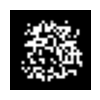

In [18]:
sample = np.random.normal(size=(20,100))
predict = generator.predict(sample)
for i in range(predict.shape[0]):
    plt.subplot(4,5,i+1)
    plt.imshow(predict[i,:], cmap='gray')
    plt.axis('off')
    plt.show()